This notebooks contains the code and data discussed in our paper "Anomaly Detection in Market Data Structures Via Machine Learning Algorithms": https://ssrn.com/abstract=3516028

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn') 
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

The swaption volatility data are stored in a csv file in the 'input_data' directory. The helper function ``get_df_from_csv(filename)`` read this data and parse some auxillary data from the header.
Note that in our git only an test example data set can be found. The results shown in the following are build on the larger data set decripted in the paper. 

In [8]:
from helper import get_df_from_csv
dfInput=get_df_from_csv('EURSWVOLN_exampleData.csv')

With the ``plot_swaption_volas(dfInput, trade_date)`` function you can plot all volatilities at given date, in the following example the 28.12.2018. (All plot functions save the images in then 'images' directory.)

cf. figure 1 paper

Saving figure stacked_autoencoder_swaption_volas_20181228


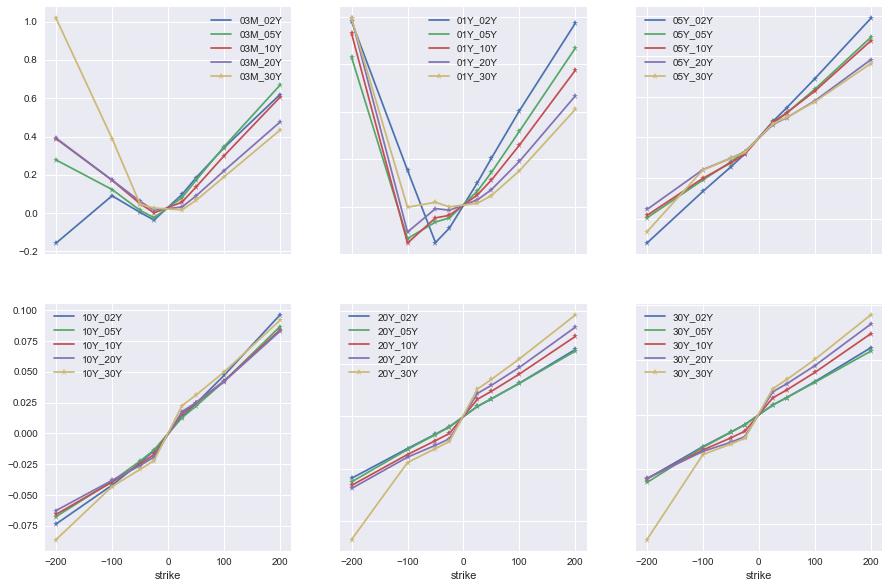

In [3]:
from helper import plot_swaption_volas
plot_swaption_volas(dfInput, '20181228')

or just the feature vector with ``plot_feature_vector(dfInput, trade_date)``

cf. figure 1 paper

Saving figure stacked_autoencoder_features_20181228


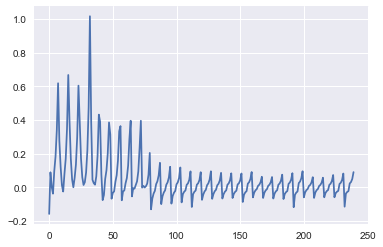

In [4]:
from helper import plot_feature_vector
plot_feature_vector(dfInput, '20181228')

As explained in the paper we implanted anomalies at the 20Y-05Y-100bps point at 28.12.2018 an try to find them (at least the biggest ones) with the algorithm. The implanted data sets are saved at synthetic dates in 1800.

cf. figure 2 paper

Saving figure stacked_autoencoder_swaption_volas2_20Y_05Y


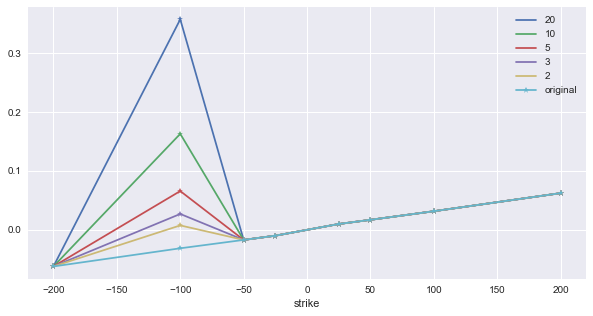

In [5]:
from helper import plot_swaption_volas2
trade_dates=['18000101','18000102','18000103','18000104','18000105','20181228']
labels=['20','10','5','3','2','original']
optionPeriodSymbol='20Y'
swapPeriodSymbol='05Y'
plot_swaption_volas2(dfInput, trade_dates, labels, optionPeriodSymbol, swapPeriodSymbol)

To get an impression about the dimensionality of the problem. One way is to peforme an principal componant analyses PCA (the special case of an autoencoder with linear activation function), which can easily done with sklearn, and have a look at the sum of the variance of the principal components.

           0
0   0.632321
1   0.795084
2   0.861486
3   0.890674
4   0.919092
5   0.940615
6   0.953236
7   0.960221
8   0.966820
9   0.971929
10  0.975887
11  0.979720
12  0.982506
13  0.984895
14  0.986814


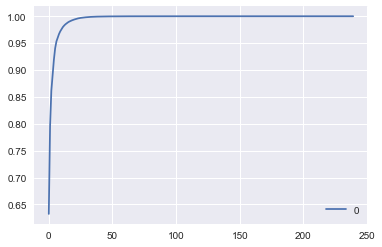

In [6]:
from sklearn.decomposition import PCA
pca=PCA()
pca.fit(dfInput['data'].values)
explained_variance_ratio_cumsum=pd.DataFrame(data=pca.explained_variance_ratio_.cumsum())
print(explained_variance_ratio_cumsum[:15])
explained_variance_ratio_cumsum.plot()

So with 5 principal components more then 91% of the variance are explained and with 10 more then 97%. In the following we use autoencoder with 5 and 10 bottlenecks, with and without denoising and compare the results.

In [2]:
n_bottlenecks=[5,5,10,10]
noise_stddevs=[0,0.01,0,0.01]

As a first step we create an 90% train an 10% test set, where the inplanted data points (1800) are neglected. 

In [3]:
from neuralnetwork import get_train_test_index
index_train, index_test = get_train_test_index(dfInput['data'][dfInput['data'].index>'1900'], split_ratio=(0.9, 0.0, 0.1))

c:\python36\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Then the autoencoder network is trained. An logfile with some information are created in the 'output_data' directory together with the loss of the train and test set.

In [ ]:
from neuralnetwork import calibrate_stacked_autoencoder
n_epoch=100
input_train=dfInput['data'].loc[index_train].values
input_test=dfInput['data'].loc[index_test].values
loss_train_test_series={}
for n_bottleneck, noise_stddev_ in zip (n_bottlenecks, noise_stddevs):
    calibrate_stacked_autoencoder(n_epoch, input_train, input_test, n_bottleneck=n_bottleneck, noise_stddev_=noise_stddev_)    

For the four combinations the losses are as expected, the test loss is al little bit larger as the train loss but both converge at a low level.

cf. figure 5 paper

Saving figure stacked_autoencoder_loss_stacked_autoencoder_noiseStdev0_bl5
Saving figure stacked_autoencoder_loss_stacked_autoencoder_noiseStdev0.01_bl5
Saving figure stacked_autoencoder_loss_stacked_autoencoder_noiseStdev0_bl10
Saving figure stacked_autoencoder_loss_stacked_autoencoder_noiseStdev0.01_bl10


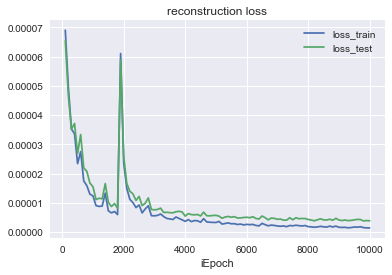

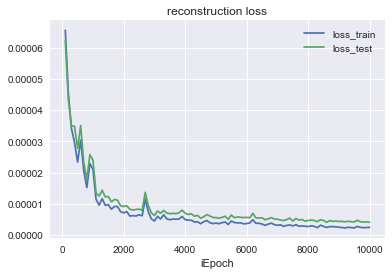

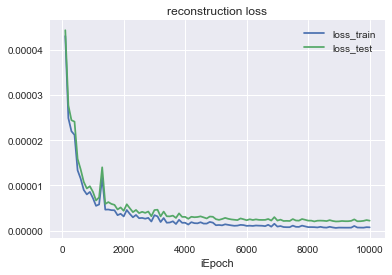

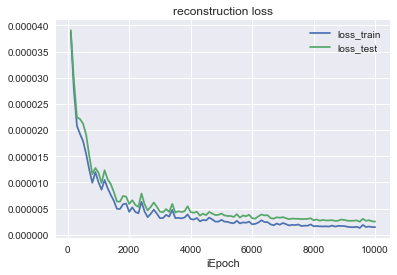

In [11]:
from helper import plot_loss
for n_bottleneck, noise_stddev in zip (n_bottlenecks, noise_stddevs):    
    plot_loss(n_bottleneck, noise_stddev)

The function ``get_prediction_from_model(dfInput, noise_stddev, n_bottleneck, index_for_statistics)`` load the saved models from 'saved_model' and calculate the predictions.

In [4]:
from neuralnetwork import get_prediction_from_model
dfResults={}
for n_bottleneck, noise_stddev in zip (n_bottlenecks, noise_stddevs):
    encoder_name, dfResult = get_prediction_from_model(dfInput, noise_stddev, n_bottleneck, dfInput['data'].loc[dfInput['data'].index>'1900'].index)
    dfResults[encoder_name] = dfResult

INFO:tensorflow:Restoring parameters from C:\Dirk_und_Henning_Repo\saved_model\stacked_autoencoder_noiseStdev0_bl5.ckpt
INFO:tensorflow:Restoring parameters from C:\Dirk_und_Henning_Repo\saved_model\stacked_autoencoder_noiseStdev0.01_bl5.ckpt
INFO:tensorflow:Restoring parameters from C:\Dirk_und_Henning_Repo\saved_model\stacked_autoencoder_noiseStdev0_bl10.ckpt
INFO:tensorflow:Restoring parameters from C:\Dirk_und_Henning_Repo\saved_model\stacked_autoencoder_noiseStdev0.01_bl10.ckpt


cf. figure 6 paper

Saving figure stacked_autoencoder_hist_stacked_autoencoder_noiseStdev0_bl5
Saving figure stacked_autoencoder_hist_stacked_autoencoder_noiseStdev0.01_bl5
Saving figure stacked_autoencoder_hist_stacked_autoencoder_noiseStdev0_bl10
Saving figure stacked_autoencoder_hist_stacked_autoencoder_noiseStdev0.01_bl10


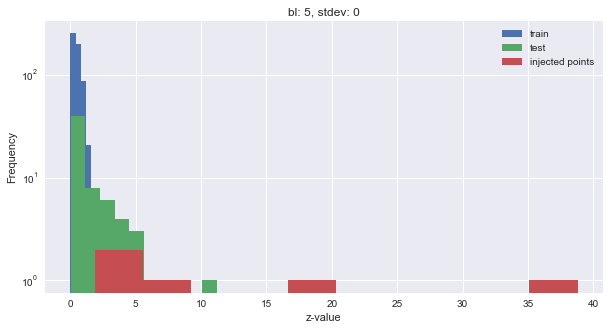

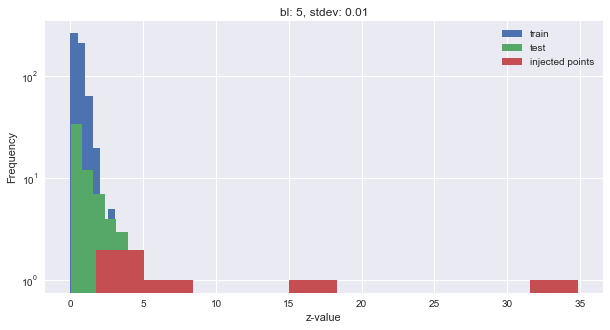

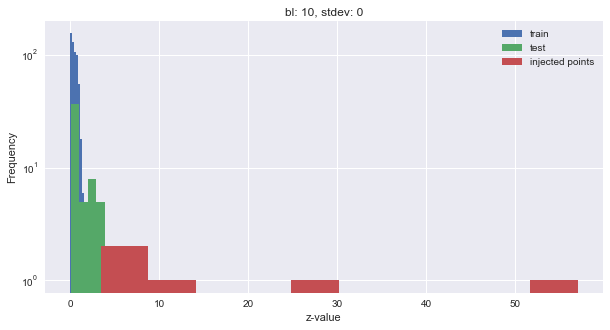

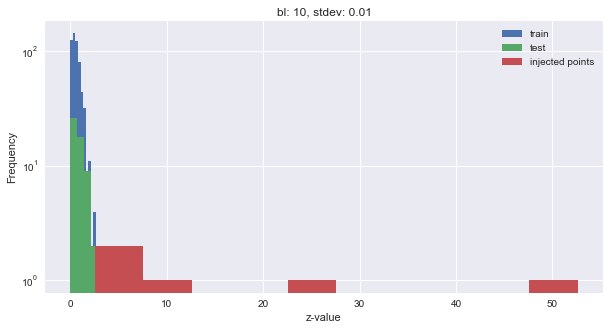

In [13]:
from helper import plot_hist
for n_bottleneck, noise_stddev in zip (n_bottlenecks, noise_stddevs):
    plot_hist(dfResults, index_train, index_test, n_bottleneck, noise_stddev)

cf. figure 7 paper

Saving figure LargeZValuesAll


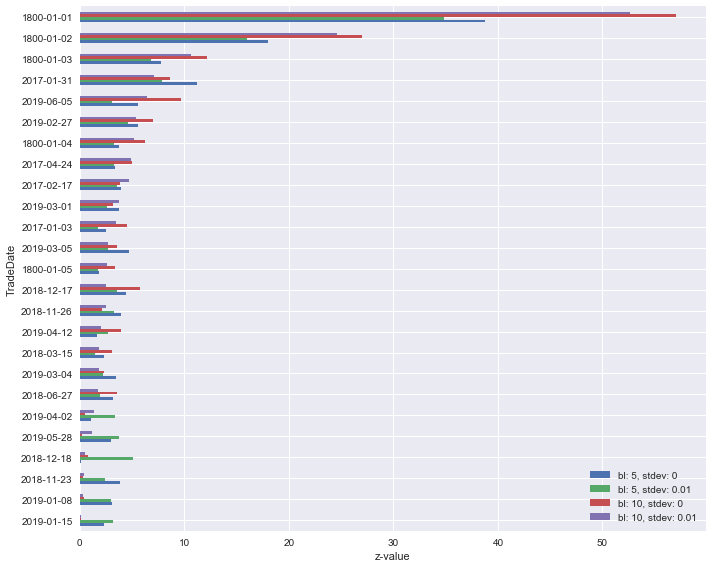

In [16]:
from helper import get_encoder_name
from helper import save_fig
n_bottleneck=10
noise_stddev=0.01
encoder_name=get_encoder_name(n_bottleneck, noise_stddev)
uniqueIndex=dfResults[encoder_name]['zValue'].loc[dfResults[encoder_name]['zValue'].zValue>3].index
for n_bottleneck, noise_stddev in zip (n_bottlenecks, noise_stddevs):
    encoder_name=get_encoder_name(n_bottleneck, noise_stddev)
    uniqueIndex=uniqueIndex.union(other=dfResults[encoder_name]['zValue'].loc[dfResults[encoder_name]['zValue'].zValue>3].index)    

dfSummaryBigZValue=pd.DataFrame()
for n_bottleneck, noise_stddev in zip (n_bottlenecks, noise_stddevs):
    encoder_name=get_encoder_name(n_bottleneck, noise_stddev)
    title='bl: ' + str(n_bottleneck) + ', stdev: ' + str(noise_stddev)
    dfSummaryBigZValue=pd.concat([dfSummaryBigZValue, dfResults[encoder_name]['zValue'].loc[uniqueIndex].rename(columns={'zValue':title})], axis=1)
df=dfSummaryBigZValue.sort_values(by=title, ascending=True)
fig, axs = plt.subplots(figsize=(10, 8))
ax=df.plot.barh(legend=True, ax=axs)
ax.set_yticklabels([pandas_datetime.strftime("%Y-%m-%d") for pandas_datetime in df.index])
ax.set(xlabel="z-value")
save_fig('LargeZValuesAll',tight_layout=True)

cf. figure 8 paper

Saving figure RLTop1


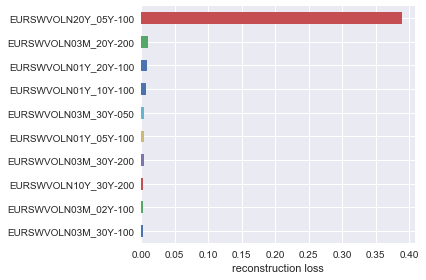

In [9]:
from helper import get_encoder_name
from helper import save_fig
trade_date='1800-01-01'
n_bottleneck=10
noise_stddev=0.01
largestRLSorted=abs(dfResults[get_encoder_name(n_bottleneck, noise_stddev)]['data']-dfInput['data']).loc[trade_date].sort_values(ascending=False)
largestRLSorted[:10]
ax=largestRLSorted[:10].sort_values().plot.barh()
ax.set(xlabel='reconstruction loss')
save_fig('RLTop1',tight_layout=True)

cf. figure 9 paper

Saving figure stacked_autoencoder_swaption_volas3_20Y_05Y_1800-01-01
Saving figure stacked_autoencoder_swaption_volas3_03M_20Y_1800-01-01
Saving figure stacked_autoencoder_swaption_volas3_01Y_20Y_1800-01-01
Saving figure stacked_autoencoder_swaption_volas3_01Y_10Y_1800-01-01
Saving figure stacked_autoencoder_swaption_volas3_03M_30Y_1800-01-01


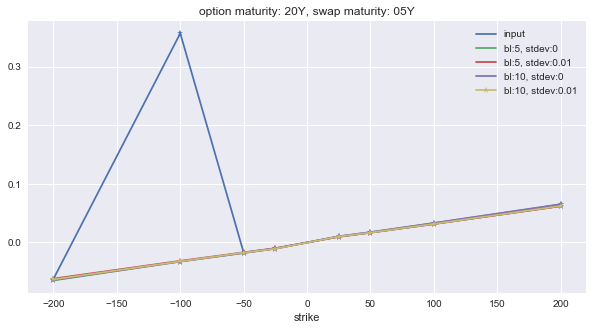

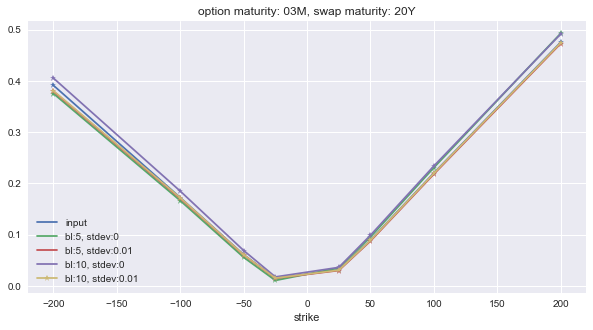

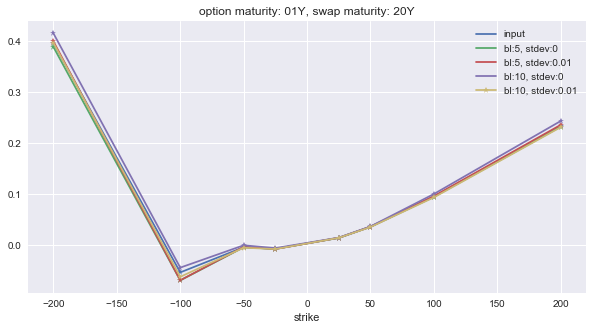

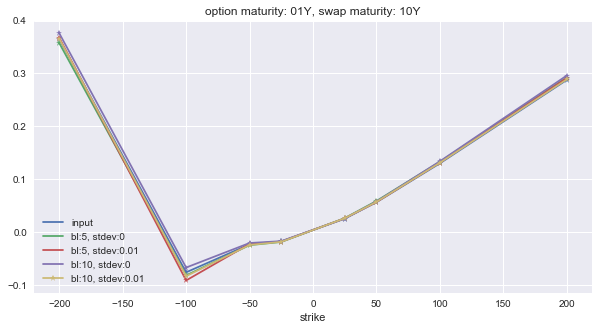

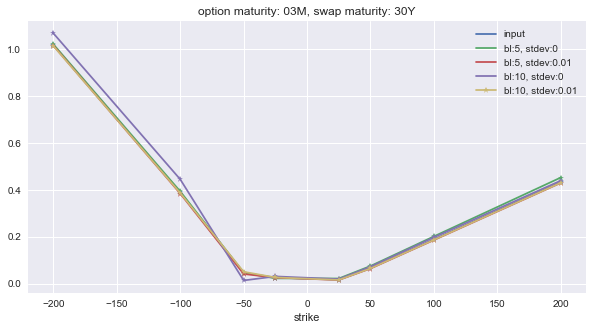

In [10]:
from helper import plot_swaption_volas3
for iTop in range(5):
    optionPeriodSymbol=largestRLSorted.keys()[iTop][9:12]
    swapPeriodSymbol=largestRLSorted.keys()[iTop][13:16]
    plot_swaption_volas3(dfInput, dfResults, n_bottlenecks, noise_stddevs, trade_date, optionPeriodSymbol, swapPeriodSymbol)

cf. figure 10 paper

Saving figure RLTop2


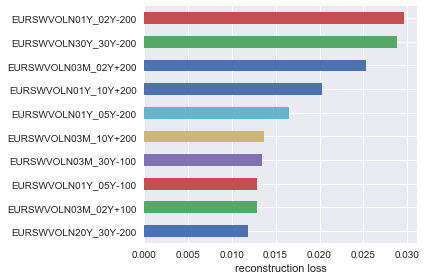

In [13]:
from helper import get_encoder_name
trade_date='2017-01-31'
n_bottleneck=10
noise_stddev=0.01
largestRLSorted=abs(dfResults[get_encoder_name(n_bottleneck, noise_stddev)]['data']-dfInput['data']).loc[trade_date].sort_values(ascending=False)
largestRLSorted[:10]
ax=largestRLSorted[:10].sort_values().plot.barh()
ax.set(xlabel='reconstruction loss')
save_fig('RLTop2',tight_layout=True)

cf. figure 11 paper (note that in the first version of the paper in figure 11 was the wrong data set)

Saving figure stacked_autoencoder_swaption_volas3_01Y_02Y_2017-01-31
Saving figure stacked_autoencoder_swaption_volas3_30Y_30Y_2017-01-31
Saving figure stacked_autoencoder_swaption_volas3_03M_02Y_2017-01-31
Saving figure stacked_autoencoder_swaption_volas3_01Y_10Y_2017-01-31
Saving figure stacked_autoencoder_swaption_volas3_01Y_05Y_2017-01-31


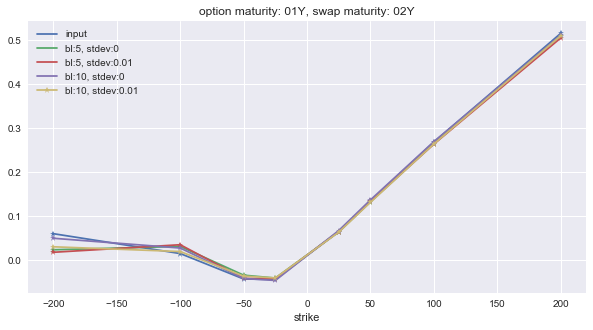

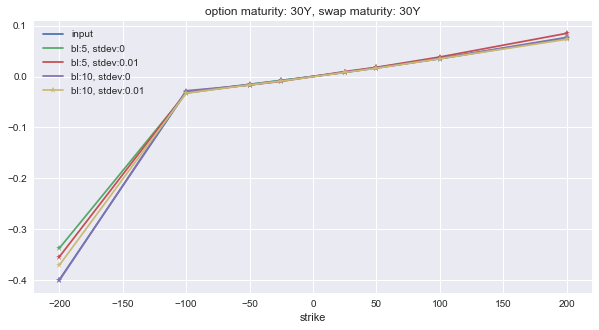

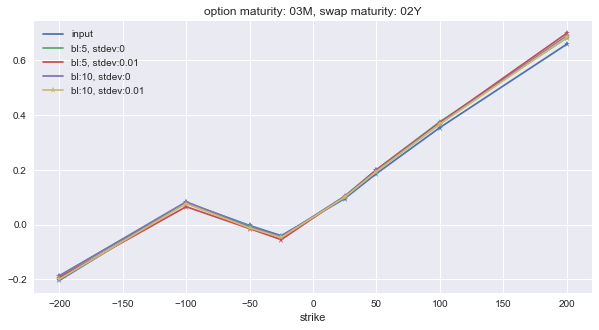

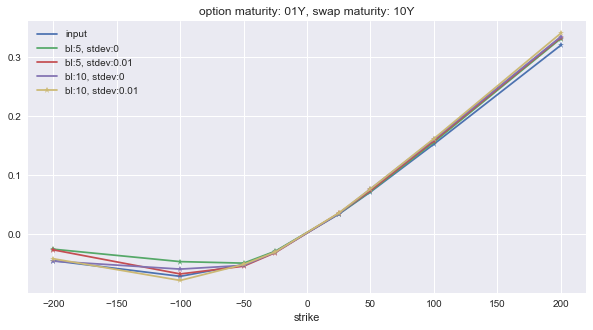

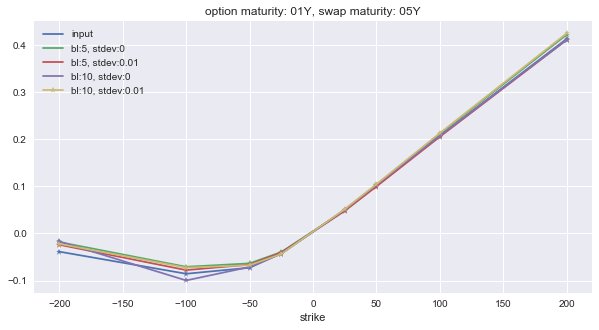

In [14]:
from helper import plot_swaption_volas3
for iTop in range(5):
    optionPeriodSymbol=largestRLSorted.keys()[iTop][9:12]
    swapPeriodSymbol=largestRLSorted.keys()[iTop][13:16]
    plot_swaption_volas3(dfInput, dfResults, n_bottlenecks, noise_stddevs, trade_date, optionPeriodSymbol, swapPeriodSymbol)

cf. figure 12 paper

Saving figure RLTop2018-12-18
Saving figure stacked_autoencoder_swaption_volas3_10Y_20Y_2018-12-18
Saving figure stacked_autoencoder_swaption_volas3_01Y_02Y_2018-12-18
Saving figure stacked_autoencoder_swaption_volas3_01Y_05Y_2018-12-18


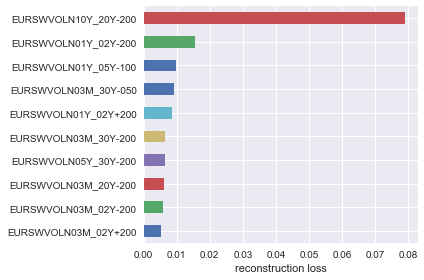

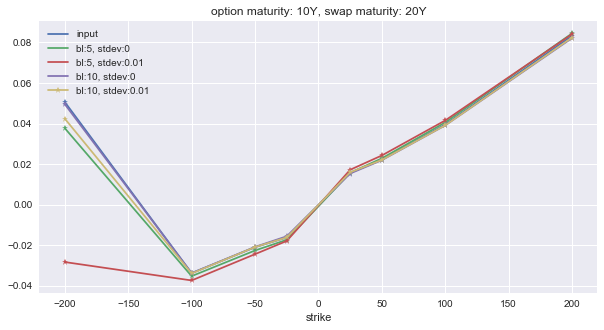

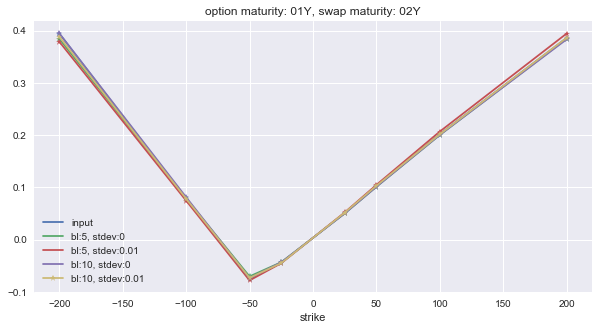

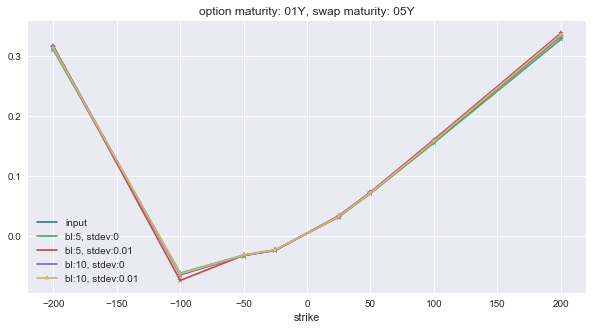

In [19]:
from helper import get_encoder_name
from helper import save_fig
trade_date='2018-12-18'
n_bottleneck=5
noise_stddev=0.01
largestRLSorted=abs(dfResults[get_encoder_name(n_bottleneck, noise_stddev)]['data']-dfInput['data']).loc[trade_date].sort_values(ascending=False)
largestRLSorted[:10]
ax = largestRLSorted[:10].sort_values().plot.barh()
ax.set(xlabel='reconstruction loss')
save_fig('RLTop'+trade_date,tight_layout=True)

from helper import plot_swaption_volas3
for iTop in range(3):
    optionPeriodSymbol=largestRLSorted.keys()[iTop][9:12]
    swapPeriodSymbol=largestRLSorted.keys()[iTop][13:16]
    plot_swaption_volas3(dfInput, dfResults, n_bottlenecks, noise_stddevs, trade_date, optionPeriodSymbol, swapPeriodSymbol)